In [24]:
import pandas as pd
from dowhy import CausalModel


In [102]:
data = pd.read_csv("./data/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")

In [103]:
male_df = data[data['segment'] != 'Womens E-Mail']
male_df.shape


In [104]:
male_df['treatment'] = male_df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1


In [105]:
# 集計
summary_by_segment = pd.pivot_table(
    data=male_df,
    values=['conversion', 'spend', 'visit'],
    index=['treatment'],
    aggfunc={'conversion': np.mean, 'spend': np.mean, 'visit': np.ma.count}
)

summary_by_segment.columns = ['conversion_rate', 'spend_mean', 'count']
summary_by_segment

,conversion_rate,spend_mean,count
treatment,,,
0,0.005726,0.652789,21306
1,0.012531,1.422617,21307


In [107]:
# バイアスのあるデータの準備
treatment_data = male_df[male_df['treatment'] == 1]
control_data = male_df[male_df['treatment'] == 0]

treatment_biased = treatment_data.drop(treatment_data[~(
    (treatment_data['history'] > 300) |
    (treatment_data['recency'] < 6) |
    (treatment_data['recency'] == 'Multichannel')
)].sample(frac=0.5, random_state=1).index)

control_biased = control_data.drop(control_data[
    (control_data['history'] > 300) |
    (control_data['recency'] < 6) |
    (control_data['recency'] == 'Multichannel')
].sample(frac=0.5, random_state=1).index)

biased_data = pd.concat([treatment_biased, control_biased])
biased_data.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1


In [108]:
# バイアスのあるデータの集計と有意差の検定
summary_by_segment_biased = pd.pivot_table(
    data=biased_data,
    values=['conversion', 'spend', 'visit'],
    index=['treatment'],
    aggfunc={'conversion': np.mean, 'spend': np.mean, 'visit': np.ma.count}
)
summary_by_segment_biased.columns = ['conversion_rate', 'spend_mean', 'count']


In [109]:
summary_by_segment_biased

,conversion_rate,spend_mean,count
treatment,,,
0,0.005165,0.634625,14907
1,0.013575,1.560682,17017


In [110]:
import numpy as np
struct_data = biased_data.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['history_segment', 'zip_code', 'channel', 'segment']


In [111]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data["treatment"] = struct_data["treatment"].astype(bool)

struct_data.head(5)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
3,9,4,675.83,1,0,0,1,2,0,0,0,0.0,True
8,9,4,675.07,1,1,0,1,1,0,0,0,0.0,True
13,2,1,101.64,0,1,2,0,2,0,1,0,0.0,True
16,5,0,29.99,1,0,1,0,1,0,0,0,0.0,True
17,9,1,112.35,1,0,0,0,2,0,0,0,0.0,True


In [114]:
G = nx.DiGraph()  # 有向グラフ (Directed Graph)

# 辺の追加 (頂点も必要に応じて追加されます)
G.add_edges_from([ ("channel", "spend"), ("channel", "treatment"), ("history", "spend"), ("history", "treatment"), ("recentry", "spend"), ("recentry", "treatment"), ("treatment", "spend")])

causal_diagram = "".join(nx.generate_gml(G))

nx.nx_agraph.view_pygraphviz(G, prog='fdp')  # pygraphvizが必要

('/tmp/tmppb4vp7n1.png',
 <AGraph <Swig Object of type 'Agraph_t *' at 0x7f73040b1f00>>)

In [115]:
model=CausalModel(
        data = struct_data,
        treatment="treatment",
        outcome="spend",
        graph=causal_diagram
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['spend']


In [116]:
model.view_model()

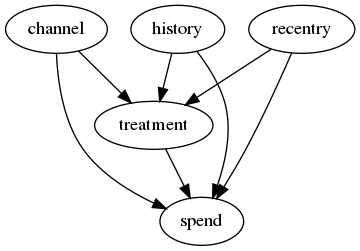

In [117]:

from IPython.display import Image, display
display(Image(filename="causal_model.png"))


In [118]:

identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['channel', 'recentry', 'history']
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                          
────────────(Expectation(spend|channel,history))
d[treatment]                                    
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→spend then P(spend|treatment,channel,history,U) = P(spend|treatment,channel,history)
### Estimand : 2
Estimand name: iv
No such variable found!



In [119]:

causal_estimate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+channel+history
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                          
────────────(Expectation(spend|channel,history))
d[treatment]                                    
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→spend then P(spend|treatment,channel,history,U) = P(spend|treatment,channel,history)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: spend~treatment+channel+history
Target units: ate

## Estimate
Mean value: 0.8234131441089386

Causal Estimate is 0.8234131441089386


In [120]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+channel+history+w_random
Refute: Add a Random Common Cause
Estimated effect:0.8234131441089386
New effect:0.8235703216755546



In [84]:
res_unobserved=model.refute_estimate(identified_estimand, causal_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+channel+history
Refute: Add an Unobserved Common Cause
Estimated effect:-0.4343443782373406
New effect:-0.4508320862545776



In [85]:

res_placebo=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~placebo+channel+history
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~placebo+channel+history
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~placebo+channel+history
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~placebo+channel+history
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~placebo+channel+history
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~placebo+channel+history
INFO:dowhy.causal_estimator:INFO: Using Propensity Score We